In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Prepro

In [4]:
# download caltech 101

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]) # imagenet stats
    ])

# dsets.Caltech101(root="./data", download=True, transform=transform)

In [3]:
import os
import math
import shutil
import random
from pathlib import Path


def split_test_train(dataset_path:Path, categories_path:Path, test_split:float=0.2)->None:
    """
    This function will MOVE the images to train and test directory respectively

    Parameters:
        dataset_path (Path): usually "data/dataset_name"
        categories_path (Path): subdirectories(categories) of the dataset
        test_split (float): test split percentage, defaults to 20%

    Returns: 
        None

    Example directory structure:
    └── data
      └── caltech101
          ├── 101_ObjectCategories
          │   ├── accordion
          │   │   ├── image_0001.jpg
          │   │   ├── image_0001.jpg
          │   │   └── ...
          │   ├── airplanes
          │   │   ├── image_0001.jpg
          │   │   ├── image_0001.jpg
          │   │   └── ...
          │   └── ...
          ├── Annotations
          └── ...

    Result:
    └── data
      └── caltech101
          ├── 101_ObjectCategories
          ├── Annotations
          ├── test  # this is the created test dir
          ├── train  # this is the created train dir
          └── ...
    """

    # directories to be created
    excl_path = ["train", "test"]

    # create test and train dirs
    for p in excl_path:
        pth = dataset_path / p
        if not pth.is_dir():
            os.makedirs(pth)

    for path in categories_path.iterdir():
        if path.is_dir() and path.stem not in excl_path:
            categories = list(path.glob("*.jpg"))
            test_images = random.sample(population=categories, 
                                        k=math.floor(len(categories)*test_split)) # 20% test
            test_subdir = dataset_path / "test" / path.stem
            train_subdir = dataset_path / "train" / path.stem

            # move test images to each respective class (/test/class_name)
            if not test_subdir.is_dir():
                # create subdir for each class
                os.makedirs(test_subdir)

                for img_path_str in test_images:
                    shutil.move(img_path_str.absolute(), test_subdir.absolute())
                    
            # move the remaining images to train directory
            if not train_subdir.is_dir():
                shutil.move(path, train_subdir)
                

In [5]:
r = Path("./data/caltech101")
c = r / "101_ObjectCategories"
# split_test_train(r, c)

## start

In [6]:
train_dataset = dsets.ImageFolder(root=r/"train", transform=transform)
test_dataset = dsets.ImageFolder(root=r/"test", transform=transform)

In [8]:
print(len(train_dataset))
print(len(test_dataset))

7356
1788


Image shape: torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


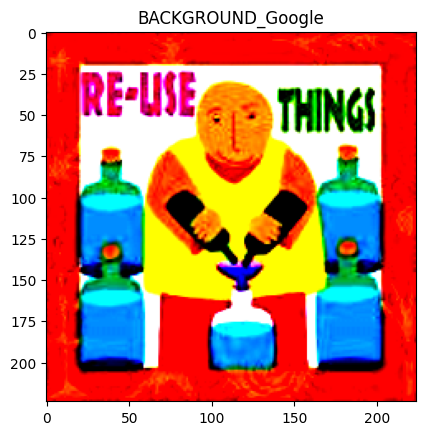

In [24]:
sample_img = train_dataset[0][0]
sample_label = test_dataset[0][1]

img, label = sample_img, sample_label
print(f"Image shape: {img.shape}")
print(sample_img.permute(1,2,0).shape)
plt.title(train_dataset.classes[label])
plt.imshow((sample_img.clamp(0,1)).permute(1,2,0)) # clamp = 

In [9]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [10]:
from torchvision import models

model_vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [15]:
for param in model_vgg.features.parameters():
    param.requires_grad = False

model_vgg.classifier[6] = nn.Linear(in_features=4096,
                                    out_features=102)

print(len(train_dataset.classes))
model_vgg.classifier

102


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=102, bias=True)
)

In [16]:
from torchinfo import summary

summary(model_vgg,
        input_size=(1, 3, 224, 224), # batch, color channel, height, width
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) 


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 102]             --                   Partial
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   False
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    (1,792)              False
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (2)                        [1, 64, 224, 224]    [1, 64, 224, 224]    (36,928)             False
│    └─ReLU (3)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   (73,856)             False
│    └─ReLU (

In [19]:
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train(model, optimizer, criterion, epochs=5):
    cost = []
    acc = []

    for epoch in range(epochs):
        _cost = 0
        model.train()
        for X, y in train_loader:
            optimizer.zero_grad()
            z = model(X)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            _cost += loss.item()
        
        correct = 0
        model.eval()
        for X, y in test_loader:
            z = model(X)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
        
        accuracy = correct / len(test_dataset)
        acc.append(accuracy)
        cost.append(_cost)


    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
        
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot( acc, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()


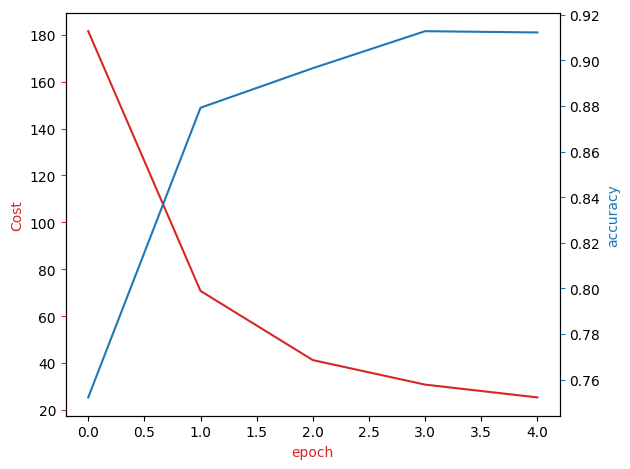

In [20]:
train(model_vgg, optimizer, criterion)

## save weights

In [82]:
import torch
from pathlib import Path

def save_model(model: torch.nn.Module, target_dir: str, model_name: str):
  
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
# save_model(model_vgg, "models", "vgg16_on_caltech101.pth")

[INFO] Saving model to: models/vgg16_on_caltech101.pth


## test on custom img

In [88]:
# load model
model__ = model_vgg
model__.load_state_dict(torch.load(Path("./models/vgg16_on_caltech101.pth"), weights_only=True))
model__

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

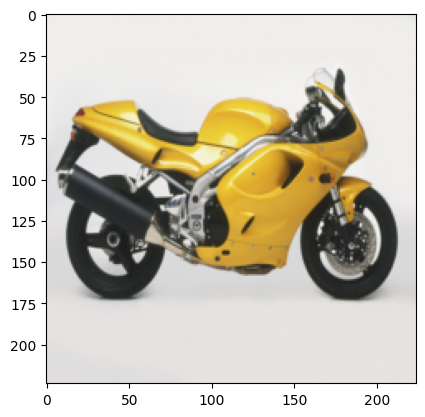

In [86]:
# prepare image

import torchvision

custom_img = torchvision.io.read_image(Path("test.jpg")) # 0 - 255
custom_img = custom_img/255

trans = transforms.Compose([
    transforms.Resize(size=(224, 224)),
])

transformed_custom_img = trans(custom_img)
# transformed_custom_img.permute(1,2,0)
plt.imshow(transformed_custom_img.permute(1,2,0))

In [87]:
# add batch 
transformed_custom_img.unsqueeze(dim=0).shape

torch.Size([1, 3, 224, 224])

In [89]:
model__.eval()
with torch.inference_mode():
    custom_image_pred = model__(transformed_custom_img.unsqueeze(dim=0))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[3.8388e-03, 5.7377e-06, 2.0653e-06, 5.1341e-07, 4.4672e-01, 2.5043e-06,
         5.1585e-02, 3.4329e-03, 3.3208e-04, 4.9785e-04, 8.9328e-04, 1.3643e-04,
         6.8154e-04, 1.9879e-04, 4.2581e-04, 3.0521e-04, 1.1808e-04, 2.5254e-03,
         1.2607e-04, 4.9072e-02, 1.6542e-04, 6.1249e-03, 6.8616e-05, 2.2589e-01,
         1.2331e-04, 9.0630e-06, 1.1907e-04, 3.4622e-03, 6.0598e-05, 2.6393e-05,
         7.2200e-06, 1.2424e-03, 1.7947e-04, 3.4020e-06, 1.0254e-04, 2.7691e-03,
         1.2779e-03, 1.5599e-04, 2.3477e-05, 6.2309e-04, 2.6914e-04, 2.4863e-05,
         3.7248e-05, 2.8855e-04, 1.7515e-04, 8.6202e-05, 1.7101e-02, 2.6322e-03,
         1.6813e-04, 3.2839e-03, 1.8752e-05, 7.8112e-04, 2.5353e-05, 3.8340e-02,
         2.8119e-05, 7.6146e-05, 1.7281e-05, 1.2048e-04, 2.5434e-06, 5.9214e-04,
         1.2271e-02, 2.2285e-03, 1.5352e-03, 8.4140e-05, 6.8461e-05, 3.5172e-05,
         7.6198e-06, 6.8588e-04, 1.8755e-02, 2.3233e-04, 8.4939e-06, 2.6485e-04,
         4.6410e-04, 9.6561e

In [90]:
class_names = train_dataset.classes

custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
class_names[custom_image_pred_labels], custom_image_pred_probs.max()

('Motorbikes', tensor(0.4467))

In [91]:
# prediction function

import torchvision


def predict(model, classes:list, file_name:str)->None:
    custom_img = torchvision.io.read_image(Path(file_name)) # 0 - 255
    custom_img = custom_img/255

    trans = transforms.Compose([
        transforms.Resize(size=(224, 224)),
    ])

    transformed_custom_img = trans(custom_img)

    # pred
    model.eval()
    with torch.inference_mode():
        custom_image_pred = model(transformed_custom_img.unsqueeze(dim=0)) # unsqeeze to add batch 

    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
    custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
    
    plt.title(f"Pred: {classes[custom_image_pred_labels]} | Conf: {(custom_image_pred_probs.max()*100):.2f}%")
    plt.imshow(transformed_custom_img.permute(1,2,0))

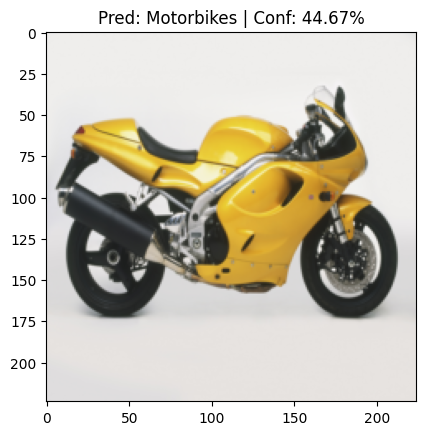

In [94]:
predict(model__, train_dataset.classes, "test.jpg")

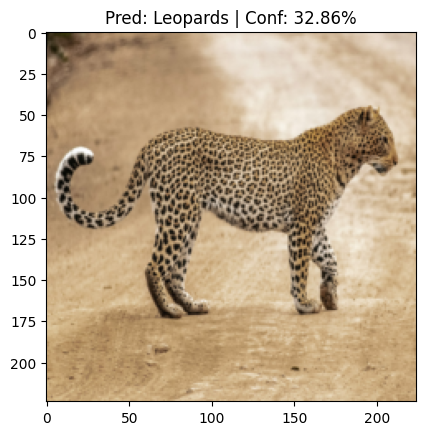

In [95]:
predict(model__, train_dataset.classes, "test2.jpg")

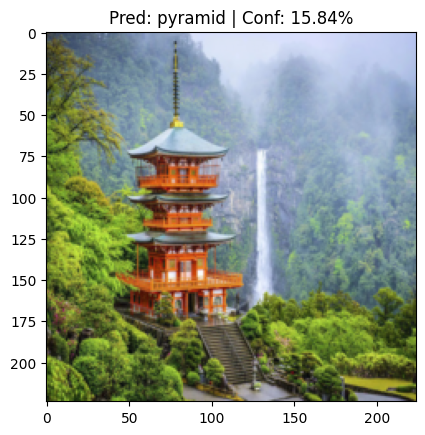

In [97]:
predict(model__, train_dataset.classes, "test3.jpg")

## with image augmentation


In [98]:
transform_augment = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]) # imagenet stats
    ])

In [ ]:
dsets.Caltech101(root="./data", download=True, transform=transform_augment)

In [100]:
r = Path("./data/caltech101")
c = r / "101_ObjectCategories"
split_test_train(r, c)

In [101]:
train_dataset = dsets.ImageFolder(root=r/"train", transform=transform_augment)
test_dataset = dsets.ImageFolder(root=r/"test", transform=transform_augment)

In [103]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

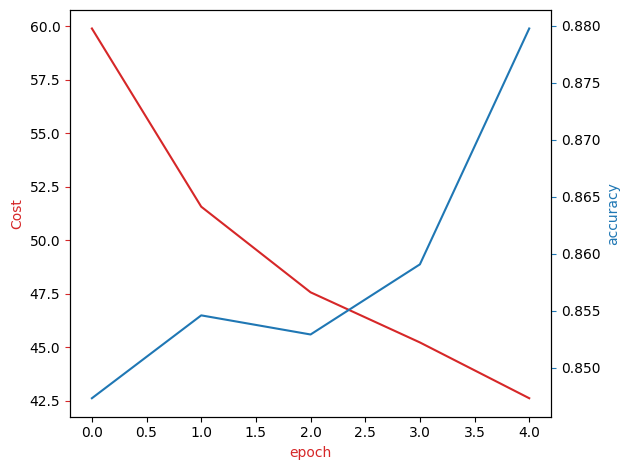

In [104]:
train(model_vgg, optimizer, criterion)